# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import CGDDPM 

# Import data

In [2]:
#Step 1: Load in the data

X = np.load('data/X.npy')
X_reg = np.load('data/X_reg.npy')
Y_reg = np.load('data/Y_reg.npy')
X_pos = np.load('data/X_pos.npy')
X_neg = np.load('data/X_neg.npy')
Cons = np.zeros((len(X_pos),1)) +1
Cons_neg = np.zeros((len(X_neg),1))

min_X = X.min(axis=0)
max_X = X.max(axis=0)


In [3]:
def min_max_norm(data):
    min_val = np.min(data)
    
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

Y_reg_normalized = min_max_norm(Y_reg)

# Visualization of cell arrangement

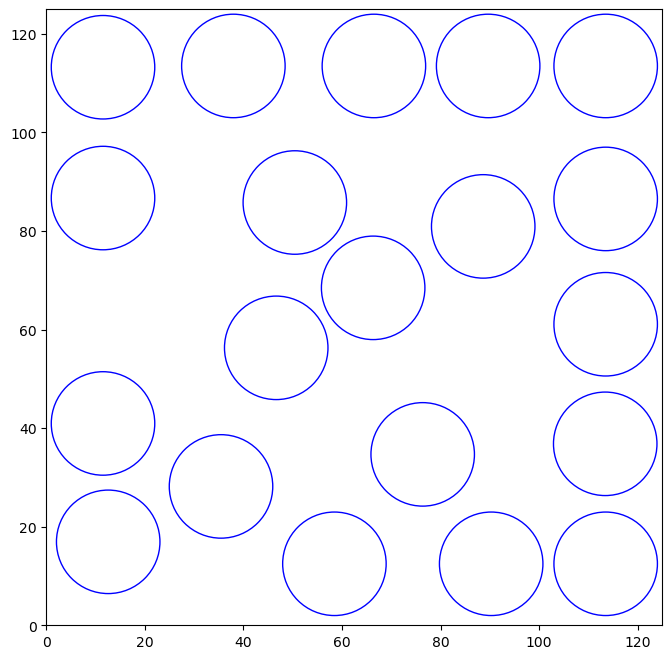

In [4]:
flattened_coords = 125*X[0].reshape(20,2)


# Circle radius for the 125x125 domain
radius = 10.5

# Preparing the figure
fig, ax = plt.subplots(figsize=(8, 8))  # Adjusted for better visualization of a 125x125 domain
ax.set_aspect('equal', adjustable='box')
plt.xlim(0, 125)
plt.ylim(0, 125)

# Plotting each circle and labeling them
for i in range(len(flattened_coords)):
    circle = plt.Circle((flattened_coords[i][0], flattened_coords[i][1]), radius, color='blue', fill=False)
    ax.add_artist(circle)

plt.show()

# Parameters of the DDPM, Classifier and Surrogate Model

In [5]:
DDPM_Dict = {
    'xdim': X.shape[1],                 # Dimension of parametric design vector
    'X_LL': min_X,                 # Lower limits of parametric design vector variables
    'X_UL': max_X,                 # Upper limits of parametric design vector variables
    'ydim': Y_reg.shape[1],                 # Number of objectives
    'cdim': len(Cons[0]),           # number of classes for classifier
    'gamma': 0.8,                       # Weight of feasibility guidance for guided sampling
    'datalength': X.shape[0],           # Number of samples
    'tdim': 256,                        # Dimension of latent variable (new setting)
    'net': [1024,1024, 1024, 1024],       # Network architecture
    'batch_size': 128,                 # Batch size
    'Training_Epochs': 10000,          # Number of training epochs
    'Diffusion_Timesteps': 1000,        # Number of diffusion timesteps
    'lr': 0.00025,                      # Learning rate
    'weight_decay': 0.0,                # Weight decay
    'device_name': 'cuda:0'           # GPU device name
}

#Regression model Dict
Classify_Dict = {
        'xdim' : len(X[0]),
        'cdim': len(Cons[0]),
        'output_dim': 1,                     # trains regression model for single objective
        'Training_Epochs': 10000,
        'lr' : 0.001,
        'weight_decay': 0,
        'device_name': 'cuda:0'}             # gpu device name


#Regression model Dict
Reg_Dict = {
        'xdim' : len(X[0]),                     # Dimension of parametric design vector
        'ydim': 1,                              # trains regression model for each objective
        'output_dim': Y_reg.shape[1],
        'tdim': 256,                            # dimension of latent variable
        'net': [256, 256],                       # network architecture        
        'Training_Epochs': 10001,               # number of training epochs
        'lr' : 0.001,                          # learning rate
        'weight_decay': 0.0,                   # weight decay
        'device_name': 'cuda:0'}               # gpu device name

# Initialize the models

In [6]:
T = CGDDPM.GuidedDiffusionEnv(DDPM_Dict,
                Classify_Dict,
                Reg_Dict,
                X=X,
                X_reg=X_reg,
                Y_reg=Y_reg_normalized,
                X_pos = X_pos,
                Cons = Cons,
                X_neg=X_neg, 
                Cons_neg=Cons_neg)


# Train the classifier

In [7]:
'''
===================================================
train classifier
==================================================
'''

T.run_train_classifier_loop(batches_per_epoch=8)


Classifier Model Training...


100%|███████████████████████████████████████████████████| 10000/10000 [08:30<00:00, 19.59it/s]

F1 score: 0.9102296450939458
Classifier Training Complete!


# Training the surrogate model

In [8]:
T.run_train_regressor_loop(batches_per_epoch=16)

Training on fold 1/5...


Epochs (Fold 1): 100%|██████████████████████████████████| 10001/10001 [01:48<00:00, 92.05it/s]


Fold 1: Train R2 = 0.9817, Test R2 = 0.6162
Training on fold 2/5...


Epochs (Fold 2): 100%|██████████████████████████████████| 10001/10001 [01:47<00:00, 92.75it/s]


Fold 2: Train R2 = 0.9853, Test R2 = 0.8024
Training on fold 3/5...


Epochs (Fold 3): 100%|██████████████████████████████████| 10001/10001 [01:46<00:00, 94.03it/s]


Fold 3: Train R2 = 0.9851, Test R2 = 0.8425
Training on fold 4/5...


Epochs (Fold 4): 100%|██████████████████████████████████| 10001/10001 [01:47<00:00, 92.72it/s]


Fold 4: Train R2 = 0.9862, Test R2 = 0.8727
Training on fold 5/5...


Epochs (Fold 5): 100%|██████████████████████████████████| 10001/10001 [01:49<00:00, 91.37it/s]

Fold 5: Train R2 = 0.9865, Test R2 = 0.8957
Average Train R2: 0.9850, Average Test R2: 0.8059
Regressor K-Fold Training Complete!


# Train the DDPM

In [9]:
T.run_train_diffusion_loop(batches_per_epoch=100)

Denoising Model Training...


 50%|██████████████████████████                          | 5001/10000 [09:06<09:09,  9.09it/s]

Step 5000/10000 Loss: 0.015331965871155262


100%|███████████████████████████████████████████████████| 10000/10000 [18:13<00:00,  9.15it/s]

Step 10000/10000 Loss: 0.011674175970256329
Denoising Model Training Complete!


# Generate samples

In [10]:
# Gen Samples:
num_samples = 1000
COND = np.zeros((num_samples,1)) + 1
# X_gen_unguided = T.gen_samples(COND)
X_gen = T.gen_perf_samples(COND,perf_weight=8)

100%|███████████████████████████████████████████████████████| 199/199 [00:06<00:00, 29.84it/s]
